In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

# Lendo os arquivos de resultados e fazendo castings

In [2]:
resultados =  pd.read_csv('../outputs_nostemmer/Resultados.csv', sep=';')
resultados_stemmer = pd.read_csv('../outputs_stemmer/Resultados.csv', sep=';')

In [3]:
resultados[['Rank', 'DocNumber', 'Score']] = resultados['List'].str.strip('[]').str.split(', ', expand=True)
resultados['QueryNumber'] = resultados['QueryNumber'].astype(int)
resultados['Rank'] = resultados['Rank'].astype(int)
resultados['DocNumber'] = resultados['DocNumber'].astype(int)
resultados['Score'] = resultados['Score'].astype(float)

In [4]:
resultados.columns

Index(['QueryNumber', 'List', 'Rank', 'DocNumber', 'Score'], dtype='object')

In [5]:
resultados_stemmer[['Rank', 'DocNumber', 'Score']] = resultados_stemmer['List'].str.strip('[]').str.split(', ', expand=True)
resultados_stemmer['Rank'] = resultados_stemmer['Rank'].astype(int)
resultados_stemmer['DocNumber'] = resultados_stemmer['DocNumber'].astype(int)
resultados_stemmer['Score'] = resultados_stemmer['Score'].astype(float)

In [6]:
esperados = pd.read_csv('../outputs_nostemmer/Esperados.csv', sep=';')
esperados['QueryNumber'] = esperados['QueryNumber'].astype(int)
esperados['DocNumber'] = esperados['DocNumber'].astype(int)
esperados['DocVotes'] = esperados['DocVotes'].astype(int)

Durante o processamento identifiquei alguns documentos sem abstract nem extract, como eles não podem ser indexados, não é razoável que eles façam parte dos valores esperados

In [54]:
def teste(resultados, esperados):
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    faltantes = set()
    
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        
        # Encontrar documentos esperados que não estão nos resultados
        documentos_faltantes = set(esperados_busca).difference(set(resultados_busca))
        
        # Adicionar documentos faltantes ao conjunto
        faltantes.update(documentos_faltantes)
    
    # Imprimir os documentos faltantes
    print(f"Documentos faltantes: {faltantes}")
    return faltantes

In [67]:
valores_remover = teste(resultados, esperados)

Documentos faltantes: set()


In [58]:
esperados.shape

(4820, 3)

In [60]:
esperados = esperados[~esperados['DocNumber'].isin(valores_remover)]

In [61]:
esperados.shape

(4710, 3)

# Gráfico de 11 pontos de precisão e recall

Para calcular precision e recall precisamos antes definir os valores para os verdadeiros positivos, falso positivo e falso negativo.
* Podemos definir o somatório de VP +FP como tudo aquilo que foi buscado pelo modelo, portanto Precisão = VP/Buscado
* Já VP + Fn pode ser difinido como o conjunto de resultados esperados, portanto Recall = VP/Esperado
* Por fim, VP isoladamente pode ser dado como a interseçao entre o esperado e o obtido VP = Buscado intersec Esperado

Calcularemos 11 pontos de precision e recall para cada query e em seguida faremos a média dos valores

In [154]:
def curva_precision_recall_11(resultados, esperados, stemmer):
    buscas_recall = []
    busca_precisions = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        precisoes = []
        recalls = []
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        dicionario_recall = {}
        for pos, buscas in enumerate(resultados_busca):
            
            buscados_ate_agora = resultados_busca[:pos+1]
            vp = len(set(esperados_busca).intersection(buscados_ate_agora))
            recall = vp/len(esperados_busca)
            precision = vp/len(buscados_ate_agora)
            recall_round = round(recall, 2)
            if busca == 92:
                print(recall)
                print(pos + 1)
                print(vp, len(esperados_busca))
                print(set(resultados_busca).difference(set(buscados_ate_agora)))

            if recall_round in dicionario_recall.keys():
                dicionario_recall[recall_round] = max(dicionario_recall[recall_round], precision)
            else:
                dicionario_recall[recall_round] = precision
            
            if recall == 1:
                break
        for valor in [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]:
            if valor not in dicionario_recall:
                disponiveis = sorted(dicionario_recall.keys())
                for disponivel in disponiveis:
                    if disponivel >= valor:
                        dicionario_recall[valor] = dicionario_recall[disponivel]
                        break
            recalls.append(valor)
            precisoes.append(dicionario_recall[valor])            
        
        buscas_recall.append(recalls)
        busca_precisions.append(precisoes)
    
    media_precision = np.mean(np.array(busca_precisions), axis=0)
    media_recall = np.mean(np.array(buscas_recall), axis=0)
    
    if stemmer:
        figure_path = '../avalia/11_precisao_recall_stemmer.pdf'
        csv_path = '../avalia/11_precisao_recall_stemmer.csv'
    else:
        figure_path = '../avalia/11_precisao_recall_nostemmer.pdf'
        csv_path = '../avalia/11_precisao_recall_nostemmer.csv'
    
    # Plotar o gráfico Precision-Recall
    plt.plot(media_recall, media_precision, marker='o', label='Precision-Recall Curve')

    # Configurações do gráfico
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(figure_path)
    # Exibir o gráfico
    plt.show()
    precision_recall_df = pd.DataFrame(np.array([media_precision, media_recall]).T, columns=["Precision", "Recall"])
    precision_recall_df.to_csv(csv_path, sep=";", index=False)

In [33]:
#def curva_precision_recall_11(resultados, esperados, stemmer):
    buscas_recall = []
    busca_precisions = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        recall = []
        precision = []
        passo = round(len(resultados_busca)/11)
        for ponto in range(11):
            buscados_ponto = resultados_busca[:(ponto+1)*passo]
            vp = len(set(esperados_busca).intersection(buscados_ponto))
            precision.append(vp/len(buscados_ponto))
            recall.append(vp/len(esperados_busca))
        buscas_recall.append(recall)
        busca_precisions.append(precision)
    media_precision = np.mean(np.array(busca_precisions), axis=0)
    media_recall = np.mean(np.array(buscas_recall), axis=0)
    
    if stemmer:
        figure_path = '../avalia/11_precisao_recall_stemmer.pdf'
        csv_path = '../avalia/11_precisao_recall_stemmer.csv'
    else:
        figure_path = '../avalia/11_precisao_recall_nostemmer.pdf'
        csv_path = '../avalia/11_precisao_recall_nostemmer.csv'
    
    # Plotar o gráfico Precision-Recall
    plt.plot(media_recall, media_precision, marker='o', label='Precision-Recall Curve')

    # Configurações do gráfico
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(figure_path)
    # Exibir o gráfico
    plt.show()
    precision_recall_df = pd.DataFrame(np.array([media_precision, media_recall]).T, columns=["Precision", "Recall"])
    precision_recall_df.to_csv(csv_path, sep=";", index=False)

0.00819672131147541
1
1 122
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

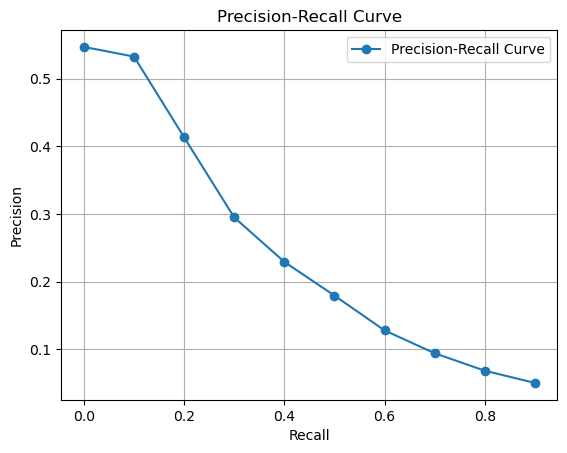

In [155]:
curva_precision_recall_11(resultados_stemmer, esperados, True)

0.94
1236


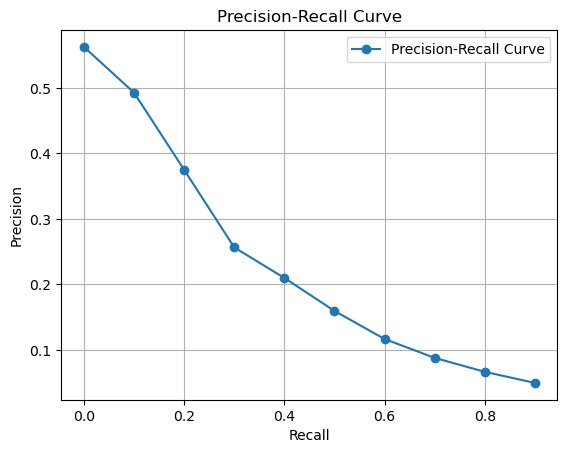

In [92]:
curva_precision_recall_11(resultados, esperados, False)

# F1 

In [7]:
def calculo_f1_score(resultados, esperados):
    buscas_recall = []
    busca_precisions = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        recall = []
        precision = []
        vp = len(set(esperados_busca).intersection(resultados_busca))
        precision.append(vp/len(resultados_busca))
        recall.append(vp/len(esperados_busca))
        buscas_recall.append(recall)
        busca_precisions.append(precision)
    media_precision = np.mean(np.array(busca_precisions), axis=0)
    media_recall = np.mean(np.array(buscas_recall), axis=0)
    f1 = (2 * media_precision * media_recall)/(media_precision + media_recall)
    return f1

In [10]:
calculo_f1_score(resultados_stemmer, esperados)

array([0.07520289])

In [11]:
calculo_f1_score(resultados, esperados)

array([0.07520289])

# Precision@K

In [12]:
def precisionK(resultados, esperados, k):
    busca_precisions = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()[:k]
        relevantes_buscados = len(set(esperados_busca).intersection(resultados_busca))
        precision_k = relevantes_buscados/k
        busca_precisions.append(precision_k)
    mean_precisions = np.mean(np.array(busca_precisions))
    return mean_precisions

Stemmer

In [13]:
#Precision 5
precisionK(resultados_stemmer, esperados, 5)

0.4646464646464647

In [14]:
#Precision 10
precisionK(resultados_stemmer, esperados, 10)

0.39999999999999997

No-Stemmer

In [15]:
#Precision 5
precisionK(resultados, esperados, 5)

0.4262626262626263

In [16]:
#Precision 10
precisionK(resultados, esperados, 10)

0.3595959595959595

# Histograma R Precision comparativo

In [21]:
#Vamos considerar os 10 primeiros valores
#Fazendo o comparativo usando (Stemmer - NoStemmer)
def Histograma_R_Precision(resultados,resultados_stemmer, esperados):
    busca_precisions = []
    busca_precisions_stemmer = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()[:10]
        resultados_stemmer_busca = resultados_stemmer.loc[resultados_stemmer['QueryNumber'] == busca, 'DocNumber'].to_list()[:10]
        relevantes_buscados = len(set(esperados_busca).intersection(resultados_busca))
        relevantes_buscados_stemmer = len(set(esperados_busca).intersection(resultados_stemmer_busca))
        precision_k = relevantes_buscados/10
        precision_k_stemmer = relevantes_buscados_stemmer/10
        busca_precisions.append(precision_k)
        busca_precisions_stemmer.append(precision_k_stemmer)
    
    comparativo = np.array(busca_precisions) - np.array(busca_precisions_stemmer)
    figure_path = '../avalia/Histograma_R_Precision.pdf'
    csv_path = '../avalia/Histograma_R_Precision.csv'

    R_precision_histogram = pd.DataFrame(np.array([comparativo, list(conjunto_buscas)]).T, columns=["Comparativo", "Buscas"])
    R_precision_histogram.to_csv(csv_path, sep=";", index=False)

    plt.bar(list(conjunto_buscas),comparativo)
    plt.title("Histograma R-Precision comparativo")
    plt.xlabel("Busca")
    plt.ylabel("R-Precision comparativa")
    plt.savefig(figure_path)
    plt.show()
    

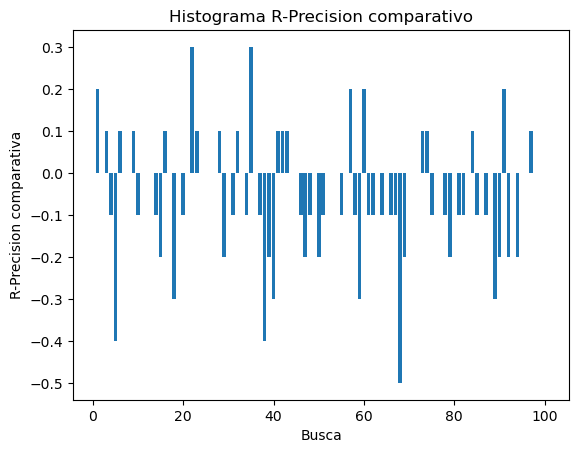

In [22]:
Histograma_R_Precision(resultados,resultados_stemmer, esperados)